In [12]:
#install.packages("magick")

Warning message in install.packages("magick"):
“installation of package ‘magick’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
#load packages
library(eulerr)
library(UpSetR)
library(jsonlite)
library(gridExtra)
library(cowplot)
library(magick)
library(grid)

selected_pops_1 <- c("European", "Eastern_Bantu", "West_Central_African", "African-American","Indigenous_American") #African-American PLUS PROXY SOURCES
selected_pops_2 <- c("European", "Eastern_Bantu", "West_Central_African", "Afro-South_American","Indigenous_American") # Afro-South_American PLUS PROXY SOURCES
selected_pops_3 <- c("European", "Eastern_Bantu", "West_Central_African", "Afro-Caribbean","Indigenous_American") # Afro-Carribean PLUS PROXY SOURCES
selected_pops_4 <- c( "African-American", "Afro-South_American", "Afro-Caribbean")
selected_pops_5 <- c("European", "Khoe-San", "Eastern_Bantu", "Asian") #admixture componesnts KS
selected_pops_6 <- c("European", "Eastern_Bantu", "Back-to-African", "Fulani", "Northeast_African") #eastern africa/nback to africa
selected_pops_7 <- c("Khoe-San", "Eastern_Bantu", "West_Central_African", "Northeast_African", "Rainforest_Hunter-Gatherer") #major continental african
selected_pops_8 <- c("European", "Eastern_Bantu", "West_Central_African", "Afro-South_American", "African-American","Afro-Caribbean","Indigenous_American") # Afro-Carribean PLUS PROXY SOURCES

#selected_pops <- c("European", "Khoe-San", "Eastern_Bantu", "Back-to-African", "Fulani", "Northeast_African", "Rainforest_Hunter-Gatherer", "West_Central_African")

In [3]:
sum_snps <- function(pop_combo, pops, counts, cutoff) {
  pop_tf <- rep(FALSE, length(pops))
  pop_tf[pop_combo] <- TRUE
  populations <- pops[pop_combo]
  if (length(pop_combo) > 1) {
    shared_common_snps <- which(rowSums(counts[,populations]>=cutoff)==length(populations))
  } else {
    shared_common_snps <- which(counts[,populations]>=cutoff)
  }
  snp_counts <- data.frame(t(c(pop_tf, sum(counts[shared_common_snps, ncol(counts)]))))
  colnames(snp_counts) <- c(pops, "shared_common_snps")
  return(snp_counts)
}

generate_euler_plot <- function(pairwise_file, poplist, selected_pops=c(), cutoff=3, common_pop="") {
  data <- read.table(
    file=pairwise_file,
    col.names=c("geovar_code", "counts"),
    colClasses=c("character", "numeric")
  )
  pops <- read.table(file=poplist)$V1
  if (length(selected_pops) < 1) {
    selected_pops <- pops
  }
  
  split.pops <- sapply(data[,1], function(a){strsplit(as.character(a),"")[[1]]})
  split.pops <- apply(split.pops,2,as.numeric)
  split.pops <- as.data.frame(t(split.pops))
  row.names(split.pops) <- 1:nrow(split.pops)
  colnames(split.pops) <- c(as.character(pops))
  data <- cbind(split.pops, data)
  data <- data[,c(selected_pops,"geovar_code","counts")]
  
  if (common_pop!=""){
    data <- data[which(data[common_pop]>=cutoff),]
  }
  
  combo_func <- Map(combn, list(1:length(selected_pops)), seq_along(1:length(selected_pops)), simplify=FALSE)
  combinations <- unlist(combo_func, recursive=FALSE)
  
  shared_common_snps <- do.call(rbind,lapply(combinations, FUN=sum_snps, pops=selected_pops, counts=data, cutoff=cutoff))
  shared_common_snps[nrow(shared_common_snps),"unique_snps"] <- shared_common_snps[nrow(shared_common_snps),"shared_common_snps"]
  # print("here are the common snps")
  #  print(shared_common_snps)
  
    for (i in (nrow(shared_common_snps)-1):1) {
    shared_common_snps[i,"unique_snps"] <- shared_common_snps[i,"shared_common_snps"] - sum(
      shared_common_snps[
        apply(
          shared_common_snps[,1:(ncol(shared_common_snps)-2)] - shared_common_snps[rep(i,nrow(shared_common_snps)),1:(ncol(shared_common_snps)-2)], 
          MARGIN=1, 
          FUN=function(x){!any(x<0)}
        ),"unique_snps"
      ], na.rm=TRUE
    )
  }
  
  euler_data <- shared_common_snps$unique_snps
  print(shared_common_snps)
  #names(euler_data) <- apply(shared_common_snps, 1, function(x){paste(head(names(x),-2)[which(x==1)],collapse="&")}) #this is where code breaks, edit this so it applyies to n - ith column
  names(euler_data) <- apply(shared_common_snps[selected_pops], 1, function(x){paste(names(x)[which(x==1)],collapse="&")}) #new fix
  #print(names(euler_data))
  return(list("sets"=euler_data,"euler"=eulerr::euler(euler_data, shape = "ellipse"),"size"=sum(shared_common_snps$unique_snps)))
}

In [ ]:
raw_euler_1 <- generate_euler_plot("/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/caapa_chr21.txt", "/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/pop_list.txt", cutoff=3,selected_pops=selected_pops_1)

raw_euler_2 <- generate_euler_plot("/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/caapa_chr21.txt", "/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/pop_list.txt", cutoff=3,selected_pops=selected_pops_2)

raw_euler_3 <- generate_euler_plot("/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/caapa_chr21.txt", "/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/pop_list.txt", cutoff=3,selected_pops=selected_pops_3)

raw_euler_4 <- generate_euler_plot("/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/caapa_chr21.txt", "/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/pop_list.txt", cutoff=3,selected_pops=selected_pops_4)

raw_euler_5 <- generate_euler_plot("/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/caapa_chr21.txt", "/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/pop_list.txt", cutoff=3,selected_pops=selected_pops_5)

raw_euler_6 <- generate_euler_plot("/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/caapa_chr21.txt", "/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/pop_list.txt", cutoff=3,selected_pops=selected_pops_6)

raw_euler_7 <- generate_euler_plot("/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/caapa_chr21.txt", "/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/pop_list.txt", cutoff=3,selected_pops=selected_pops_7)

raw_euler_8 <- generate_euler_plot("/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/caapa_chr21.txt", "/quobyte/bmhenngrp/from-lssc0/projects/CAAPA2_functional_annotation/geovar/data/pop_list.txt", cutoff=3,selected_pops=selected_pops_8)


In [ ]:
selected_pops_1 <- c("European", "Eastern_Bantu", "West_Central_African", "African-American","Indigenous_American") #African-American PLUS PROXY SOURCES
selected_pops_2 <- c("European", "Eastern_Bantu", "West_Central_African", "Afro-South_American","Indigenous_American") # Afro-South_American PLUS PROXY SOURCES
selected_pops_3 <- c("European", "Eastern_Bantu", "West_Central_African", "Afro-Caribbean","Indigenous_American") # Afro-Carribean PLUS PROXY SOURCES
selected_pops_4 <- c( "African-American", "Afro-South_American", "Afro-Caribbean")
selected_pops_5 <- c("European", "Khoe-San", "Eastern_Bantu", "Asian") #admixture componesnts KS
selected_pops_6 <- c("European", "Eastern_Bantu", "Back-to-African", "Fulani", "Northeast_African") #eastern africa/nback to africa
selected_pops_7 <- c("Khoe-San", "Eastern_Bantu", "West_Central_African", "Northeast_African", "Rainforest_Hunter-Gatherer") #major continental african
selected_pops_8 <- c("European", "Eastern_Bantu", "West_Central_African", "Afro-South_American", "African-American","Afro-Caribbean","Indigenous_American") # Afro-Carribean PLUS PROXY SOURCES


In [5]:
custom_labels_all <- c(
  "European" = "European",
  "Eastern_Bantu" = "Eastern Bantu",
  "West_Central_African" = "West Central African",
  "African-American" = "African-American",
  "Indigenous_American" = "Indigenous American",
    "Afro-South_American" = "Afro-South American",
    "Afro-Caribbean" = "Afro Caribbean",
    "Indigenous_American" ="Indigenous American",
    "Asian" ="Asian"
    
    
) 


custom_labels <- c(
  "European" = "European",
  "Eastern_Bantu" = "Eastern Bantu",
  "West_Central_African" = "West Central African",
  "African-American" = "African-American",
  "Indigenous_American" = "Indigenous American",
    "Afro-South_American" = "Afro-South American",
    "Afro-Caribbean" = "Afro Caribbean"
    
) 

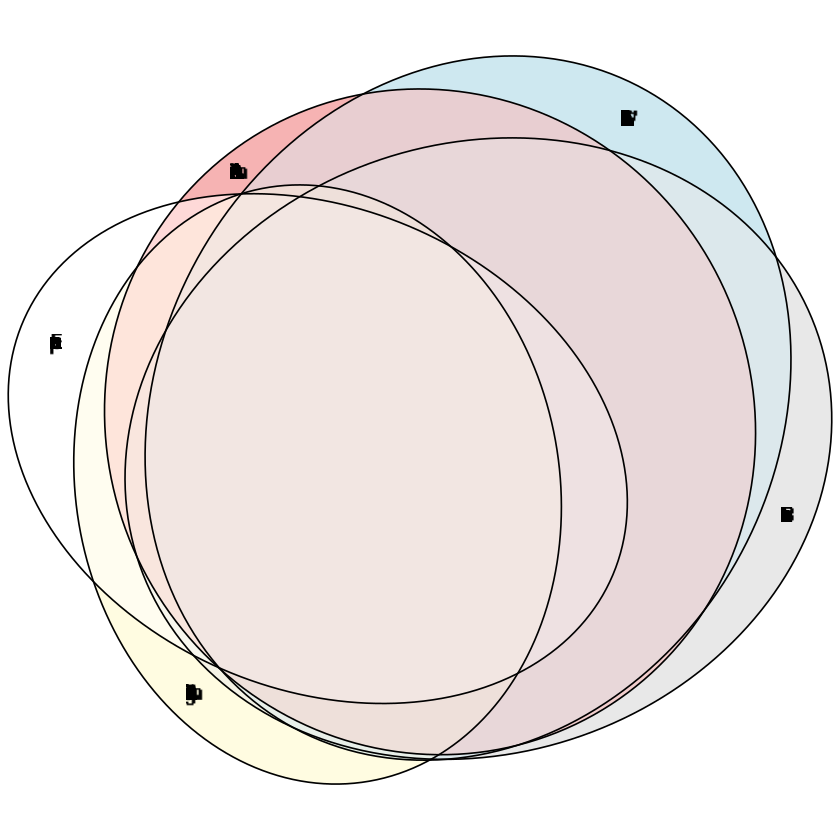

In [6]:
plot(
  raw_euler_1$euler,
  labels = custom_labels_all,
  fills = list(alpha = 0.6),
  edges = TRUE
)

In [ ]:
png("euler1.png", width = 1300, height = 1000, res = 200)

par(mar = c(6, 6, 6, 6))  # generous margins

plot(
  raw_euler_1$euler,
  labels = custom_labels,
  fills = list(alpha = 0.6),
  edges = TRUE
)

dev.off()

pdf 
  2

pdf 
  2

Warning message:
“package ‘ggplot2’ was built under R version 4.4.3”


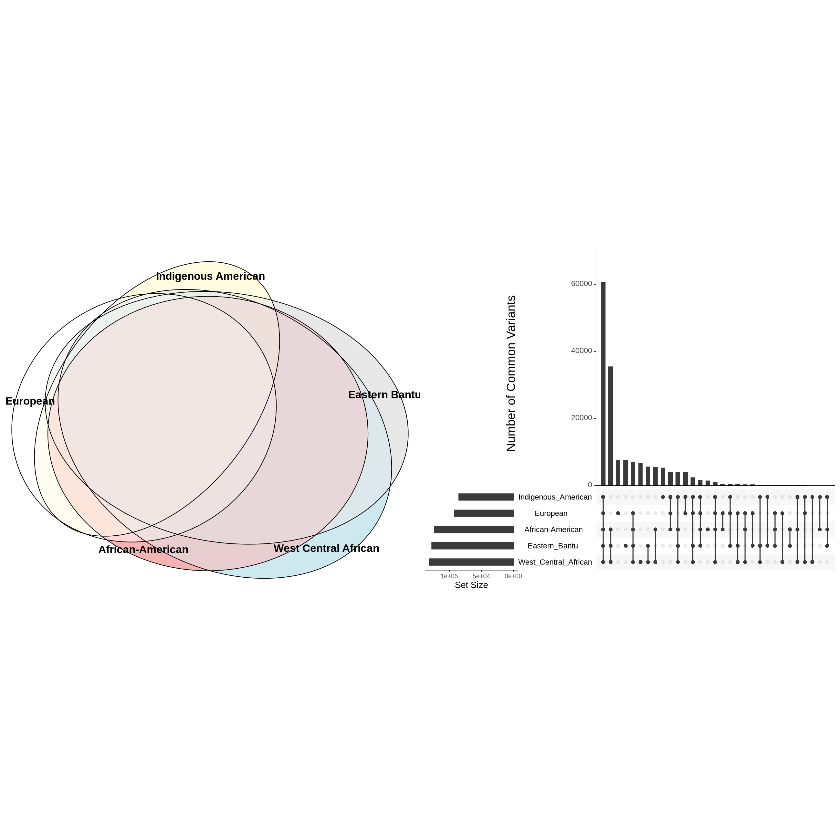

In [ ]:
# UpSet plot
png("upset_plot1.png", width = 1200, height = 1000, res = 150)
UpSetR::upset(
  fromExpression(raw_euler_1$sets),
  order.by = "freq",
  show.numbers = "no",
  mainbar.y.label = "Number of Common Variants",
  sets.x.label = "Set Size",
  text.scale = c(2, 1.5, 1.5, 1.2, 1.5, 2)
)
dev.off()

# Read images
euler_img1 <- magick::image_read("euler1.png")
upset_img1 <- magick::image_read("upset_plot1.png")

# Convert to grobs
euler_grob1 <- grid::rasterGrob(euler_img1, interpolate = TRUE)
upset_grob1<- grid::rasterGrob(upset_img1, interpolate = TRUE)

# Combine with cowplot
cowplot::plot_grid(
  euler_grob1,
  upset_grob1,
  ncol = 2,
  rel_widths = c(1, 1)
)

library(ggplot2)
ggsave("combined_figure.png", width = 12, height = 6, dpi = 300)

 

In [10]:
png("euler2.png", width = 1300, height = 1000, res = 200)
custom_labels2 <- c(
  "European" = "European",
  "Eastern_Bantu" = "Eastern Bantu",
  "West_Central_African" = "West Central African",
  "Indigenous_American" = "Indigenous American",
  "Afro-South_American" = "Afro-South American"
) 
par(mar = c(6, 6, 6, 6))  # generous margins

plot(
  raw_euler_2$euler,
  #labels = custom_labels2,
  fills = list(alpha = 0.6),
  edges = TRUE
)

dev.off()

# UpSet plot
png("upset_plot2.png", width = 1200, height = 1000, res = 150)
UpSetR::upset(
  fromExpression(raw_euler_2$sets),
  order.by = "freq",
  show.numbers = "no",
  mainbar.y.label = "Number of Common Variants",
  sets.x.label = "Set Size",
  text.scale = c(2, 1.5, 1.5, 1.2, 1.5, 2)
)
dev.off()

# Read images
euler_img2 <- magick::image_read("euler2.png")
upset_img2 <- magick::image_read("upset_plot2.png")

# Convert to grobs
euler_grob2 <- grid::rasterGrob(euler_img2, interpolate = TRUE)
upset_grob2<- grid::rasterGrob(upset_img2, interpolate = TRUE)

# Combine with cowplot
cowplot::plot_grid(
  euler_grob2,
  upset_grob2,
  ncol = 2,
  rel_widths = c(1, 1)
)

library(ggplot2)
ggsave("combined_figure2.png", width = 12, height = 6, dpi = 300)

pdf 
  2

pdf 
  2

ERROR: Error in loadNamespace(x): there is no package called ‘magick’


pdf 
  2

pdf 
  2

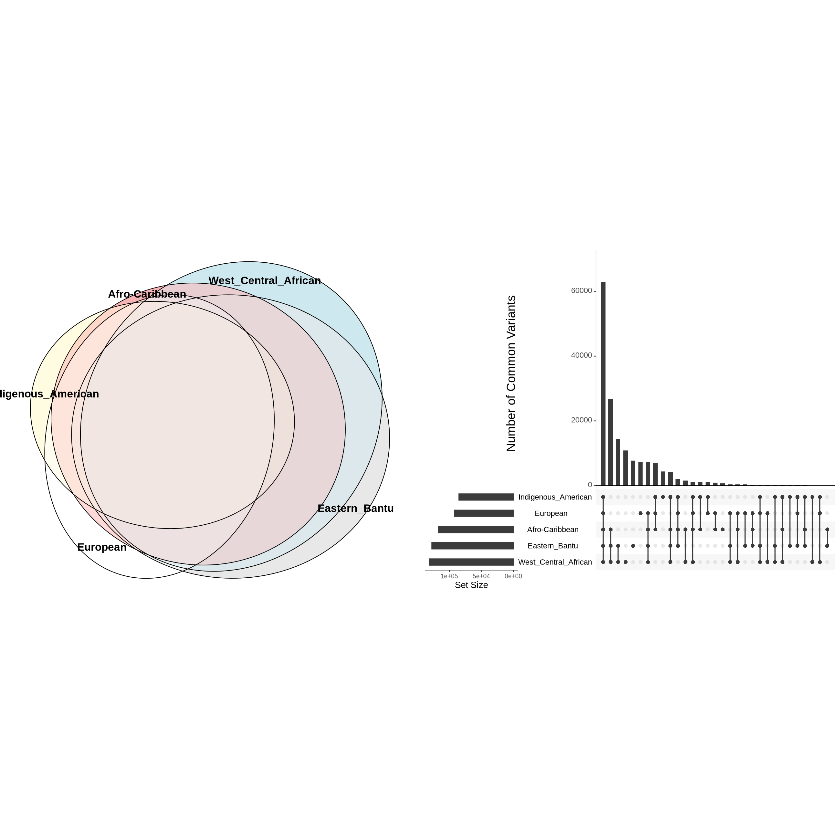

In [87]:
png("euler3.png", width = 1300, height = 1000, res = 200)

par(mar = c(6, 6, 6, 6))  # generous margins
custom_labels3 <- c(
  "European" = "European",
  "Eastern_Bantu" = "Eastern Bantu",
  "West_Central_African" = "West Central African",
  "Indigenous_American" = "Indigenous American",
  "Afro-Caribbean" = "Afro Caribbean"
    
) 
plot(
  raw_euler_3$euler,
  #labels = custom_labels3,
  fills = list(alpha = 0.6),
  edges = TRUE
)

dev.off()

# UpSet plot
png("upset_plot3.png", width = 1200, height = 1000, res = 150)
UpSetR::upset(
  fromExpression(raw_euler_3$sets),
  order.by = "freq",
  show.numbers = "no",
  mainbar.y.label = "Number of Common Variants",
  sets.x.label = "Set Size",
  text.scale = c(2, 1.5, 1.5, 1.2, 1.5, 2)
)
dev.off()

# Read images
euler_img3 <- magick::image_read("euler3.png")
upset_img3 <- magick::image_read("upset_plot3.png")

# Convert to grobs
euler_grob3 <- grid::rasterGrob(euler_img3, interpolate = TRUE)
upset_grob3<- grid::rasterGrob(upset_img3, interpolate = TRUE)

# Combine with cowplot
cowplot::plot_grid(
  euler_grob3,
  upset_grob3,
  ncol = 2,
  rel_widths = c(1, 1)
)

library(ggplot2)
ggsave("combined_figure3.png", width = 12, height = 6, dpi = 300)